In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.data.load_data import prepare_data
from src.models.anomaly_detectors import ZScoreDetector, AutoencoderDetector

In the context of the DroneRF dataset, a "segment" refers to a single recording of RF data. Each segment represents a continuous period of data collection for capturing a specific drone activity or background RF noise. The dataset splits each segment into two parts: "High" and "Low". "High" refers to the higher frequency components of the signal while "Low" refers to the lower frequency components of the signal. Let's start off by using 5 pairs of segments

## Loading in and preprocessing DroneRF data

Here, we are combining segments into NumPy format and creating spectrograms for each windowed portion. This was we get way more training samples.

In [2]:
base_path = './data/raw/known_signal_subset'
data = prepare_data(base_path, num_segments = 10)

print(f"Loaded data shape: {data.shape}")

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/rdura/repos/signal-fingerprinting/src/data/load_data.py:16: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
100%|███████████████████████████████████████████| 10/10 [02:13<00:00, 13.40s/it]


Loaded data shape: (99980, 512, 2, 1)


In [3]:
# Saving to numpy file
processed_path = './data/processed/spectrogram_data'
np.save(processed_path, data)

In [4]:
# Used when data preprocessing is already done
# data = np.load('./data/processed/spectrogram_data.npy')

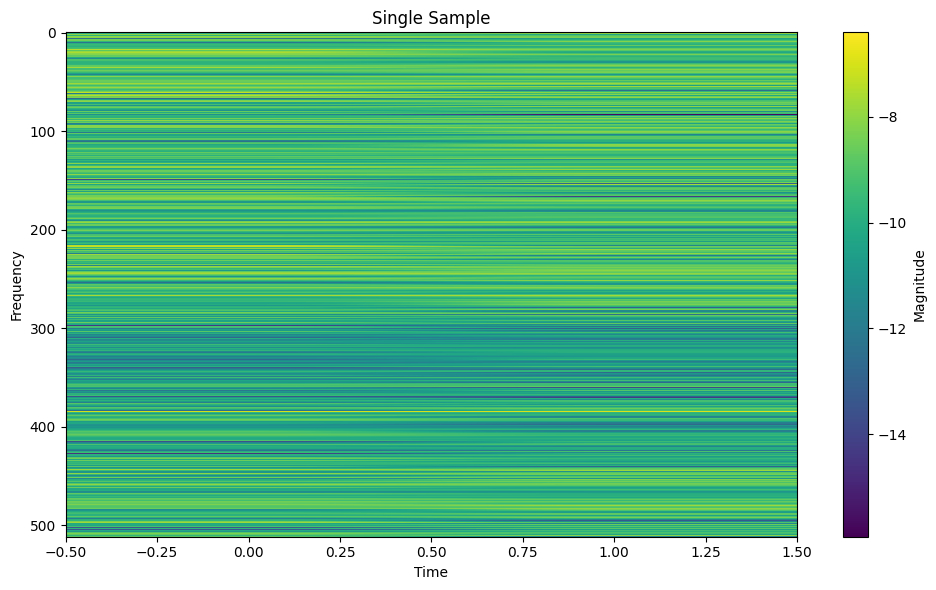

In [10]:
sample = data[200]
sample = sample.squeeze()
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(sample), aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('Single Sample')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [11]:
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [12]:
print(f"Data shape: {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Min value: {np.min(data)}")
print(f"Max value: {np.max(data)}")
print(f"Mean value: {np.mean(data)}")
print(f"Median value: {np.median(data)}")

Data shape: (99980, 512, 2, 1)
Data type: float32
Min value: -1.0
Max value: 1.0
Mean value: -0.9997304677963257
Median value: -0.999930739402771


In [13]:
# Z-Score Detector
z_detector = ZScoreDetector(threshold=3.0)
z_detector.fit(train_data)
z_anomalies = z_detector.predict(test_data)
print(f"Z-Score Detector found {sum(z_anomalies)} anomalies")

Z-Score Detector found 19147 anomalies


In [15]:
#Autoencoder Detector
input_shape = (256, 6, 1)  # Matches your data shape
ae_detector = AutoencoderDetector(input_shape, threshold=0.1)
ae_detector.fit(train_data, epochs=10, batch_size=32)
ae_anomalies = ae_detector.predict(test_data)
print(f"Autoencoder Detector found {sum(ae_anomalies)} anomalies")

Epoch 1/10


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 256, 6, 1), found shape=(None, 512, 2)